In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy
from matplotlib import pyplot as plt
from scipy.stats import boxcox
# from statsmodels.stats.diagnostic import het_breuschpagan

np.random.seed(21)
df_train = pd.read_csv('2016_cleaned.csv')

target = 'logerror'
pid = 'parcelid'

plt.style.use('seaborn-darkgrid') # Set Plotting Aesthetic Defaults
%matplotlib inline

In [2]:
_, l = boxcox(df_train.logerror + np.abs(df_train.logerror.min()) + .000001) 
print(f'Y Box-Cox lambda: {l:.3f}')

Y Box-Cox lambda: 0.970


In [3]:
continuous_cols = [
    'bedroomcnt','buildingqualitytypeid','calculatedbathnbr','calculatedfinishedsquarefeet','fireplacecnt','lotsizesquarefeet','poolcnt','roomcnt','unitcnt','yearbuilt','structuretaxvaluedollarcnt','assessmentyear','landtaxvaluedollarcnt'
    
]

for i in continuous_cols:
    print(i)
    var = df_train.loc[:, i]
    
    if var.min() <= 0:
        
        var = var + np.abs(var.min()) + .000001
        df_train.loc[:, i] = df_train.loc[:, i] + np.abs(df_train.loc[:, i].min()) + .000001
        
    _, l = boxcox(var) 
    
    df_train.loc[:, i] = np.power(df_train.loc[:, i], l)
    
    print(f' Box-Cox Transformed lambda: {l:.3f}')

bedroomcnt
 Box-Cox Transformed lambda: 0.680
buildingqualitytypeid
 Box-Cox Transformed lambda: 1.457
calculatedbathnbr
 Box-Cox Transformed lambda: 0.215
calculatedfinishedsquarefeet
 Box-Cox Transformed lambda: -0.149
fireplacecnt
 Box-Cox Transformed lambda: -0.670
lotsizesquarefeet
 Box-Cox Transformed lambda: -0.395
poolcnt
 Box-Cox Transformed lambda: -0.349
roomcnt
 Box-Cox Transformed lambda: -0.258
unitcnt
 Box-Cox Transformed lambda: -6.172
yearbuilt
 Box-Cox Transformed lambda: 11.583
structuretaxvaluedollarcnt
 Box-Cox Transformed lambda: 0.057
assessmentyear
 Box-Cox Transformed lambda: 0.943
landtaxvaluedollarcnt


/Users/bennett/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:910: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/Users/bennett/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1959: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/Users/bennett/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1960: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/bennett/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1961: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/bennett/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1962: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)


 Box-Cox Transformed lambda: 0.118


In [4]:
for i in continuous_cols:
    print(i)
    var = df_train.loc[:, i]
    
    _, l = boxcox(var) 
    
    
    print(f' Box-Cox Transformed lambda: {l:.3f}')

bedroomcnt
 Box-Cox Transformed lambda: 1.000
buildingqualitytypeid
 Box-Cox Transformed lambda: 1.000
calculatedbathnbr
 Box-Cox Transformed lambda: 1.000
calculatedfinishedsquarefeet
 Box-Cox Transformed lambda: 1.000
fireplacecnt
 Box-Cox Transformed lambda: 1.000
lotsizesquarefeet
 Box-Cox Transformed lambda: 1.000
poolcnt
 Box-Cox Transformed lambda: 1.000
roomcnt
 Box-Cox Transformed lambda: 1.000
unitcnt
 Box-Cox Transformed lambda: 1.000
yearbuilt
 Box-Cox Transformed lambda: 1.000
structuretaxvaluedollarcnt


/Users/bennett/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/Users/bennett/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Users/bennett/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


 Box-Cox Transformed lambda: 1.000
assessmentyear
 Box-Cox Transformed lambda: 5.022
landtaxvaluedollarcnt
 Box-Cox Transformed lambda: 1.000


In [5]:
def run_multiple_regression_ols(df, X_list, print_output = False):

    X = sm.add_constant(df.loc[:, X_list]) # Predictor Matrix: IV + Constant
    y = df.Y # Prediction Targets

    # Fit, summarize OLS regression
    model = sm.OLS(y, X)
    result = model.fit()
    
    if print_output == True:
        
        print(result.summary())
        
    resids = result.resid
    preds = result.predict(X)
    
    return result, resids, preds

def normal_probability_plot(result, resids):
    
    resid_df = pd.DataFrame(resids, columns = ['resid'])
    resid_df = resid_df.sort_values(by = 'resid').reset_index(drop = True).reset_index().rename({'index':'k'}, axis = 1)
    resid_df.k = resid_df.k + 1
    resid_df['expected_value'] = resid_df.apply(lambda x: np.sqrt(result.mse_resid) * scipy.stats.norm().ppf((x.k - .375)/(len(resid_df) + .25)), axis = 1)

    fig = plt.scatter(resid_df.expected_value, resid_df.resid)

    plt.xlabel('Expected')
    plt.ylabel('Residual')
    plt.title('Normal Probability Plot')
    
    plt.show()

In [6]:
drop_cols = ['fips_6111.0','heatingorsystemtypeid_24.0','regionidcity_9840.0','propertylandusetypeid_275.0','propertycountylandusecode_96','assessmentyear','yearbuilt']
df_train['Y'] = df_train.logerror
training_cols = [i for i in df_train.columns if i not in [pid, target,'transactiondate','Y','census_tract','censustractandblock']]
training_cols = [i for i in training_cols if i not in drop_cols]

In [7]:
result, resids, preds = run_multiple_regression_ols(df_train, training_cols, True)

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     5.054
Date:                Sun, 10 Apr 2022   Prob (F-statistic):          1.77e-142
Time:                        19:51:03   Log-Likelihood:                 37519.
No. Observations:               89670   AIC:                        -7.450e+04
Df Residuals:                   89402   BIC:                        -7.198e+04
Df Model:                         267                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

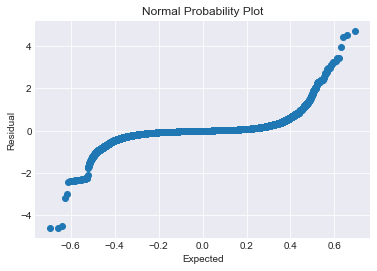

In [8]:
normal_probability_plot(result, resids)